# Task: File Ingestion and Schema validation

Take any csv/text file of 2+ GB of your choice. --- (You can do this assignment on Google colab)

Read the file ( Present approach of reading the file )

Try different methods of file reading eg: Dask, Modin, Ray, pandas and present your findings in term of computational efficiency

Perform basic validation on data columns : eg: remove special character , white spaces from the col name

As you already know the schema hence create a YAML file and write the column name in YAML file. --define separator of
read and write file, column name in YAML

Validate number of columns and column name of ingested file with YAML.

Write the file in pipe separated text file (|) in gz format.

Create a summary of the file:

Total number of rows,

total number of columns

file size

In [1]:
!pip3 install dask==2021.3.0

In [2]:
!pip3 install graphviz==0.16

In [3]:
import os
import time

In [4]:
#Size of the file
os.path.getsize('C:/Users/anmul/Downloads/yellow_tripdata_2015-01.csv')

1985964692

## Read in the data with Dask

In [5]:
#Looking at the features
# dask dataframe  : # https://github.com/dask/dask-tutorial/blob/master/07_dataframe.ipynb
from dask import dataframe as dd
start = time.time()
month = dd.read_csv('C:/Users/anmul/Downloads/yellow_tripdata_2015-01.csv')
end = time.time()
print("Read csv with dask: ",(end-start),"sec")

C:\Users\anmul\anaconda3\lib\site-packages\dask\dataframe\utils.py:374: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\anmul\anaconda3\lib\site-packages\dask\dataframe\utils.py:374: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\anmul\anaconda3\lib\site-packages\dask\dataframe\utils.py:374: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


Read csv with dask:  0.013208866119384766 sec


In [6]:
print(month.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


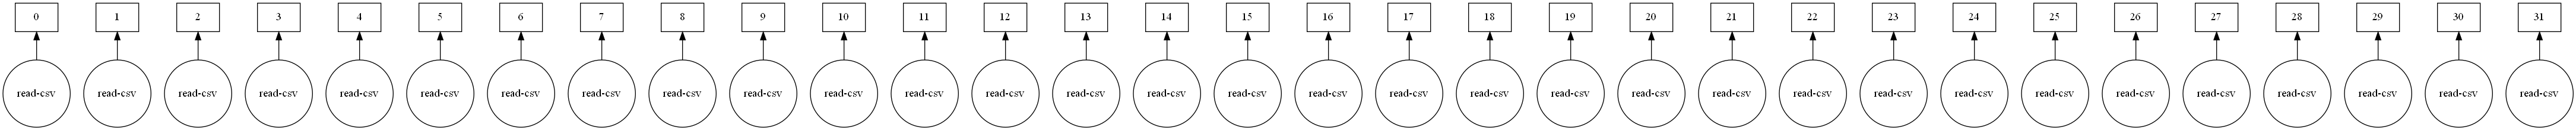

In [7]:
# However unlike Pandas, operations on dask.dataframes don't trigger immediate computation, 
# instead they add key-value pairs to an underlying Dask graph. Recall that in the diagram below, 
# circles are operations and rectangles are results.
#https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
# to see the visulaization you need to install graphviz
# pip3 install graphviz if this doesnt work please check the install_graphviz.jpg in the drive
month.visualize()

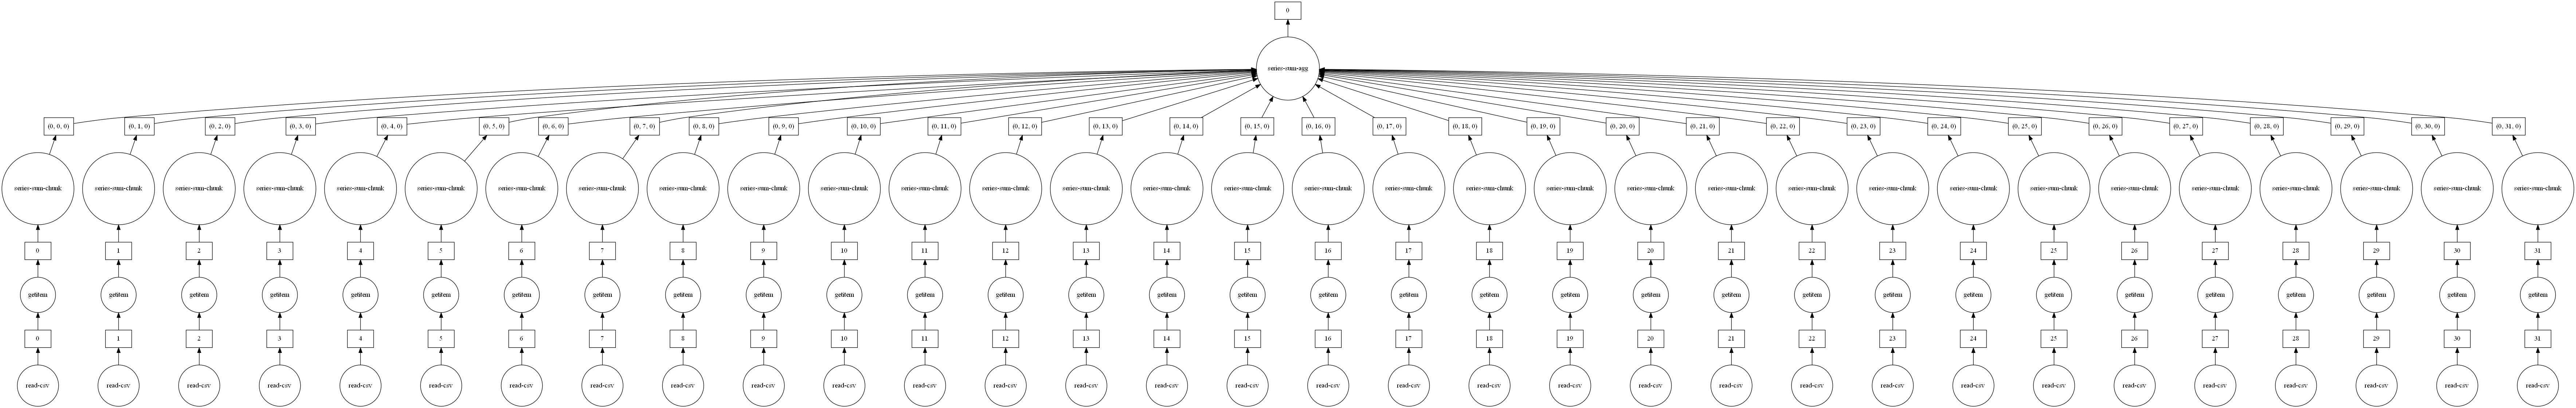

In [8]:
month.fare_amount.sum().visualize()

## Read in the data with Pandas

In [9]:
import pandas as pd
start = time.time()
df = pd.read_csv('C:/Users/anmul/Downloads/yellow_tripdata_2015-01.csv')
end = time.time()
print("Read csv with pandas: ",(end-start),"sec")

Read csv with pandas:  30.591835021972656 sec


## Read in the data with Modin and Ray

##### Here Dask is better than Pandas, Modin and Ray, with the least reading time of 0.012 sec

# 1. Pickup Latitude and Pickup Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with pickups which originate within New York.

In [10]:
!pip install folium

In [11]:
!pip install gpxpy

In [12]:
import folium 
import dask.dataframe as dd#similar to pandas

import pandas as pd#pandas to create small dataframes 

# pip3 install foliun
# if this doesnt work refere install_folium.JPG in drive
#import folium #open street map

# unix time: https://www.unixtimestamp.com/
import datetime #Convert to unix time

import time #Convert to unix time

# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays

# matplotlib: used to plot graphs
import matplotlib
# matplotlib.use('nbagg') : matplotlib uses this protocall which makes plots more user intractive like zoom in and zoom out
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  

# this lib is used while we calculate the stight line distance between two (lat,lon) pairs in miles
import gpxpy.geo #Get the haversine distance

from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os

# download migwin: https://mingw-w64.org/doku.php/download/mingw-builds
# install it in your system and keep the path, migw_path ='installed path'
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [13]:
# Plotting pickup cordinates which are outside the bounding box of New-York 
# we will collect all the points outside the bounding box of newyork city to outlier_locations
outlier_locations = month[((month.pickup_longitude <= -74.15) | (month.pickup_latitude <= 40.5774)| \
                   (month.pickup_longitude >= -73.7004) | (month.pickup_latitude >= 40.9176))]

# creating a map with the a base location
# read more about the folium here: http://folium.readthedocs.io/en/latest/quickstart.html

# note: you dont need to remember any of these, you dont need indeepth knowledge on these maps and plots

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)

<b>Observation:-</b> As you can see above that there are some points just outside the boundary but there are a few that are in either South america, Mexico or Canada

# 2. Dropoff Latitude & Dropoff Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with dropoffs which are within New York.

In [14]:
# Plotting dropoff cordinates which are outside the bounding box of New-York 
# we will collect all the points outside the bounding box of newyork city to outlier_locations
outlier_locations = month[((month.dropoff_longitude <= -74.15) | (month.dropoff_latitude <= 40.5774)| \
                   (month.dropoff_longitude >= -73.7004) | (month.dropoff_latitude >= 40.9176))]

# creating a map with the a base location
# read more about the folium here: http://folium.readthedocs.io/en/latest/quickstart.html

# note: you dont need to remember any of these, you dont need indeepth knowledge on these maps and plots

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)

Observation:- The observations here are similar to those obtained while analysing pickup latitude and longitude

# 3. Trip Durations:

According to NYC Taxi & Limousine Commision Regulations the maximum allowed trip duration in a 24 hour interval is 12 hours.

In [15]:
#The timestamps are converted to unix so as to get duration(trip-time) & speed also pickup-times in unix are used while binning 

# in out data we have time in the formate "YYYY-MM-DD HH:MM:SS" we convert thiss sting to python time formate and then into unix time stamp
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())



# we return a data frame which contains the columns
# 1.'passenger_count' : self explanatory
# 2.'trip_distance' : self explanatory
# 3.'pickup_longitude' : self explanatory
# 4.'pickup_latitude' : self explanatory
# 5.'dropoff_longitude' : self explanatory
# 6.'dropoff_latitude' : self explanatory
# 7.'total_amount' : total fair that was paid
# 8.'trip_times' : duration of each trip
# 9.'pickup_times : pickup time converted into unix time 
# 10.'Speed' : velocity of each trip
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

# print(frame_with_durations.head())
#  passenger_count	trip_distance	pickup_longitude	pickup_latitude	dropoff_longitude	dropoff_latitude	total_amount	trip_times	pickup_times	Speed
#   1                  1.59	      -73.993896        	40.750111    	-73.974785      	40.750618           	17.05   	 18.050000	1.421329e+09	5.285319
#   1               	3.30    	-74.001648      	40.724243   	-73.994415      	40.759109           	17.80   	19.833333	1.420902e+09	9.983193
#   1               	1.80     	-73.963341      	40.802788     	-73.951820      	40.824413           	10.80   	10.050000	1.420902e+09	10.746269
#   1               	0.50    	-74.009087      	40.713818    	-74.004326       	40.719986           	4.80    	1.866667	1.420902e+09	16.071429
#   1               	3.00    	-73.971176      	40.762428    	-74.004181      	40.742653           	16.30   	19.316667	1.420902e+09	9.318378
frame_with_durations = return_with_trip_times(month)

In [16]:
frame_with_durations.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421367e+09,5.285319
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420940e+09,9.983193
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420940e+09,10.746269
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420940e+09,16.071429
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420940e+09,9.318378


<IPython.core.display.Javascript object>


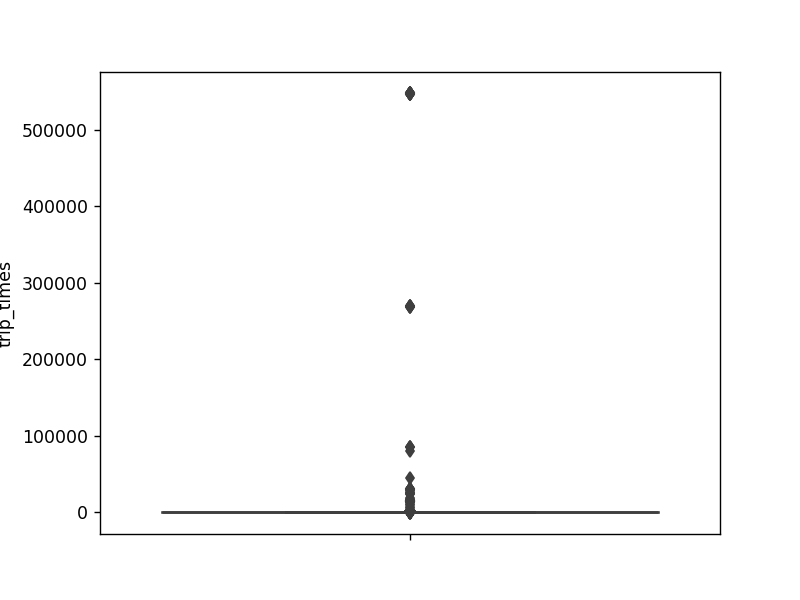

In [17]:
# the skewed box plot shows us the presence of outliers 
sns.boxplot(y="trip_times", data =frame_with_durations)
plt.show()

In [18]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -1211.0166666666667
10 percentile value is 3.8333333333333335
20 percentile value is 5.383333333333334
30 percentile value is 6.816666666666666
40 percentile value is 8.3
50 percentile value is 9.95
60 percentile value is 11.866666666666667
70 percentile value is 14.283333333333333
80 percentile value is 17.633333333333333
90 percentile value is 23.45
100 percentile value is  548555.6333333333


In [19]:
#looking further from the 99th percecntile
for i in range(90,100):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 23.45
91 percentile value is 24.35
92 percentile value is 25.383333333333333
93 percentile value is 26.55
94 percentile value is 27.933333333333334
95 percentile value is 29.583333333333332
96 percentile value is 31.683333333333334
97 percentile value is 34.46666666666667
98 percentile value is 38.71666666666667
99 percentile value is 46.75
100 percentile value is  548555.6333333333


In [20]:
#removing data based on our analysis and TLC regulations
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)]

<IPython.core.display.Javascript object>


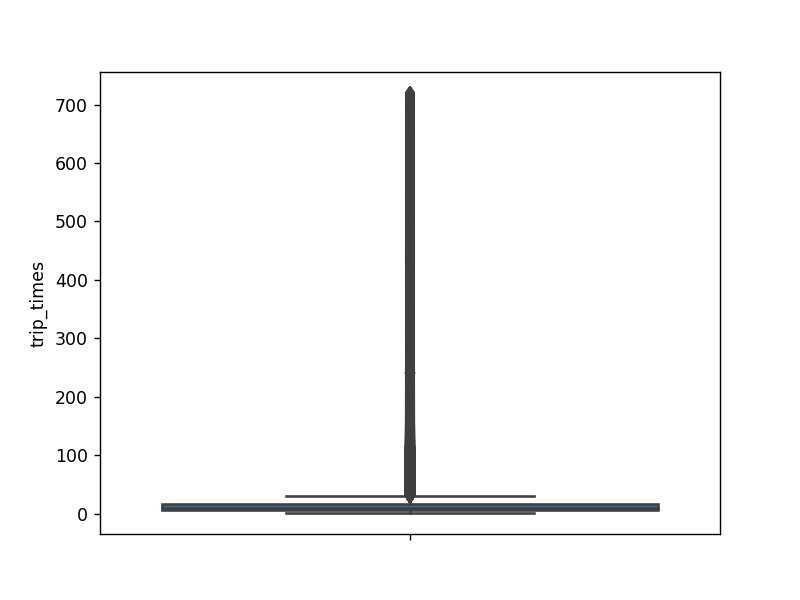

In [21]:
#box-plot after removal of outliers
sns.boxplot(y="trip_times", data =frame_with_durations_modified)
plt.show()

In [22]:
#converting the values to log-values to chec for log-normal
import math
frame_with_durations_modified['log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]

In [24]:
!pip3 install scipy

<IPython.core.display.Javascript object>


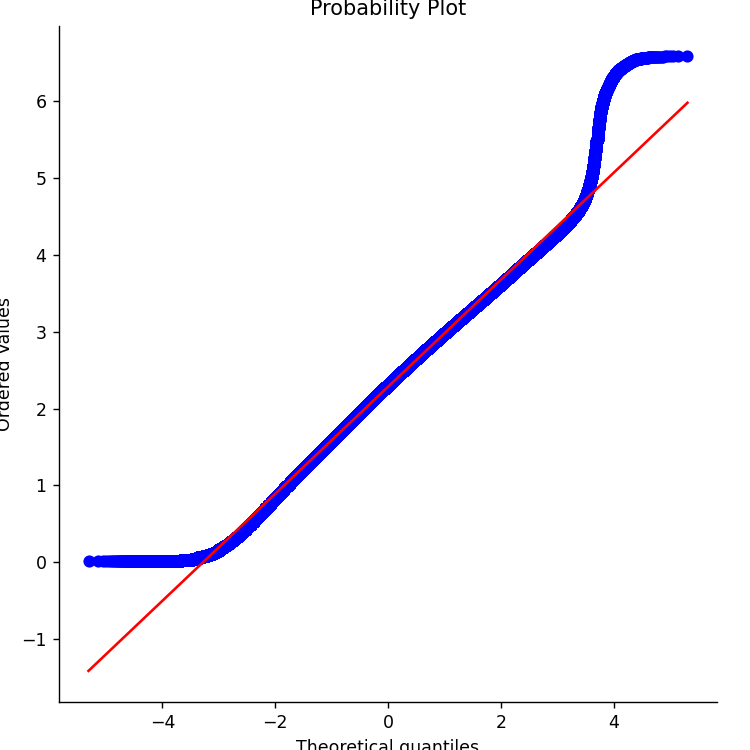

In [25]:
#Q-Q plot for checking if trip-times is log-normal
import os
os.environ["PATH"] += os.pathsep + 'c:/users/anmul/anaconda3/lib/site-packages (from scipy) (1.19.2)/'
import scipy
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()

# 4. Speed

<IPython.core.display.Javascript object>


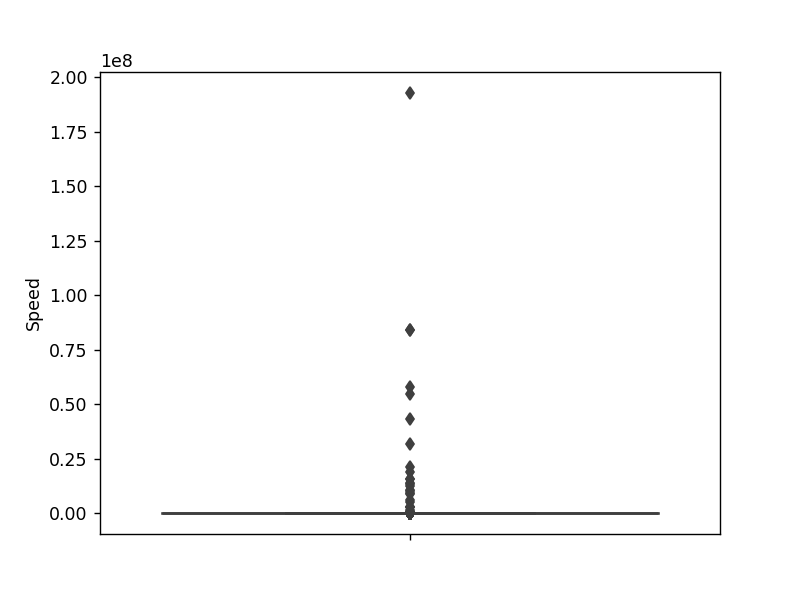

In [26]:
# check for any outliers in the data after trip duration outliers removed
# box-plot for speeds with outliers

frame_with_durations_modified['Speed'] = 60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =frame_with_durations_modified)
plt.show()

In [27]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 6.409495548961425
20 percentile value is 7.80952380952381
30 percentile value is 8.929133858267717
40 percentile value is 9.98019801980198
50 percentile value is 11.06865671641791
60 percentile value is 12.286689419795222
70 percentile value is 13.796407185628745
80 percentile value is 15.963224893917962
90 percentile value is 20.186915887850468
100 percentile value is  192857142.85714284


In [28]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 20.186915887850468
91 percentile value is 20.91645569620253
92 percentile value is 21.752988047808763
93 percentile value is 22.721893491124263
94 percentile value is 23.844155844155843
95 percentile value is 25.182552504038775
96 percentile value is 26.80851063829787
97 percentile value is 28.84304932735426
98 percentile value is 31.591128254580514
99 percentile value is 35.7513566847558
100 percentile value is  192857142.85714284


In [29]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<45.31)]

In [30]:
#avg.speed of cabs in New-York
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

12.450173996028015

##### The avg speed in Newyork speed is 12.45miles/hr, so a cab driver can travel 2 miles per 10min on avg.

# 4. Trip Distance

<IPython.core.display.Javascript object>


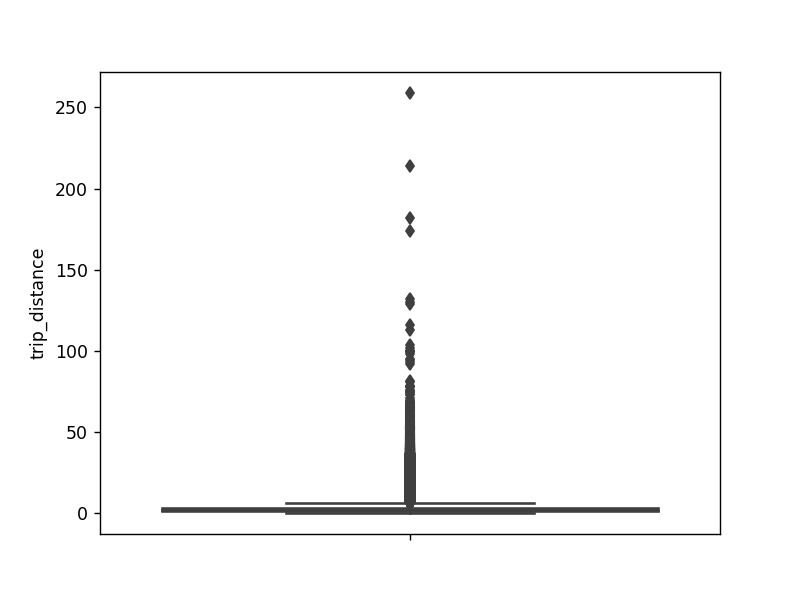

In [31]:
# up to now we have removed the outliers based on trip durations and cab speeds
# lets try if there are any outliers in trip distances
# box-plot showing outliers in trip-distance values
sns.boxplot(y="trip_distance", data =frame_with_durations_modified)
plt.show()

In [32]:
#calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.66
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.39
50 percentile value is 1.69
60 percentile value is 2.07
70 percentile value is 2.6
80 percentile value is 3.6
90 percentile value is 5.97
100 percentile value is  258.9


In [33]:
#calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 5.97
91 percentile value is 6.45
92 percentile value is 7.07
93 percentile value is 7.85
94 percentile value is 8.72
95 percentile value is 9.6
96 percentile value is 10.6
97 percentile value is 12.1
98 percentile value is 16.03
99 percentile value is 18.17
100 percentile value is  258.9


In [34]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.17
99.1 percentile value is 18.37
99.2 percentile value is 18.6
99.3 percentile value is 18.83
99.4 percentile value is 19.13
99.5 percentile value is 19.5
99.6 percentile value is 19.96
99.7 percentile value is 20.5
99.8 percentile value is 21.22
99.9 percentile value is 22.57
100 percentile value is  258.9


In [35]:
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<23)]

<IPython.core.display.Javascript object>


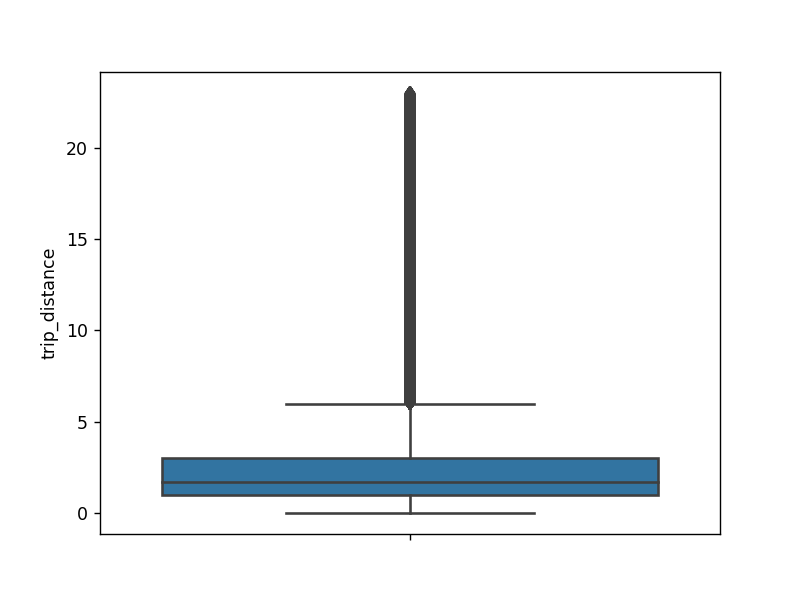

In [36]:
#box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

# 5. Total Fare

<IPython.core.display.Javascript object>


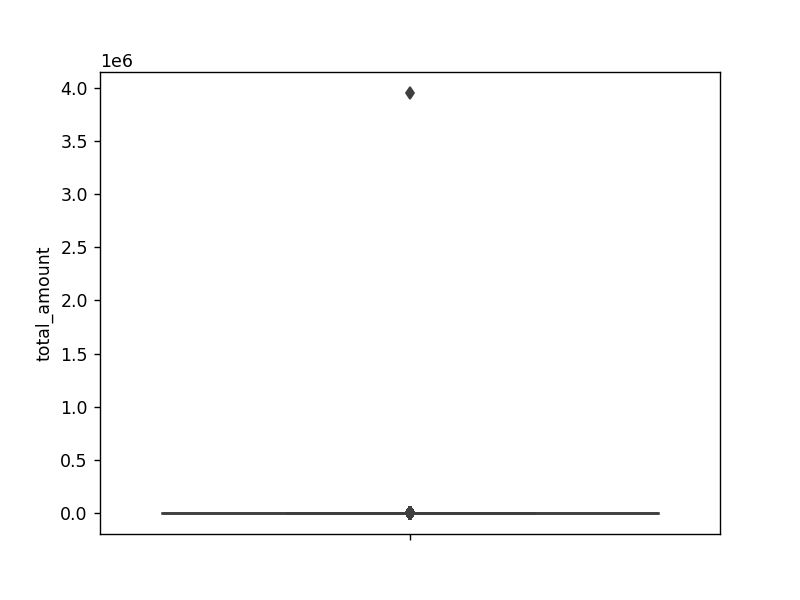

In [37]:
# up to now we have removed the outliers based on trip durations, cab speeds, and trip distances
# lets try if there are any outliers in based on the total_amount
# box-plot showing outliers in fare
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

In [38]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -242.55
10 percentile value is 6.3
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.8
50 percentile value is 11.16
60 percentile value is 12.8
70 percentile value is 14.8
80 percentile value is 18.3
90 percentile value is 25.8
100 percentile value is  3950611.6


In [39]:
#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 25.8
91 percentile value is 27.3
92 percentile value is 29.3
93 percentile value is 31.8
94 percentile value is 34.8
95 percentile value is 38.53
96 percentile value is 42.6
97 percentile value is 48.13
98 percentile value is 58.13
99 percentile value is 66.13
100 percentile value is  3950611.6


In [40]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 66.13
99.1 percentile value is 68.13
99.2 percentile value is 69.6
99.3 percentile value is 69.6
99.4 percentile value is 69.73
99.5 percentile value is 69.75
99.6 percentile value is 69.76
99.7 percentile value is 72.58
99.8 percentile value is 75.35
99.9 percentile value is 88.28
100 percentile value is  3950611.6


Observation:- As even the 99.9th percentile value doesnt look like an outlier,as there is not much difference between the 99.8th percentile and 99.9th percentile, we move on to do graphical analyis

<IPython.core.display.Javascript object>


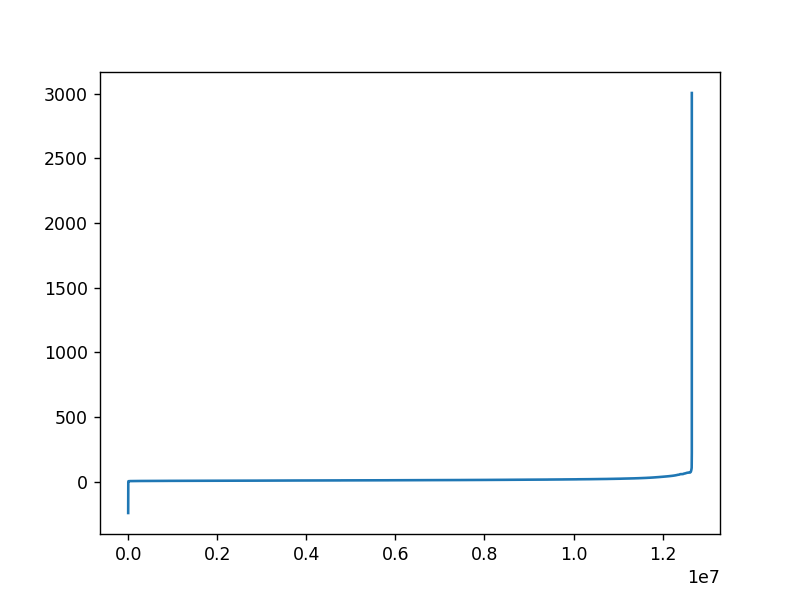

In [41]:
#below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers
# plot the fare amount excluding last two values in sorted data
plt.plot(var[:-2])
plt.show()

<IPython.core.display.Javascript object>


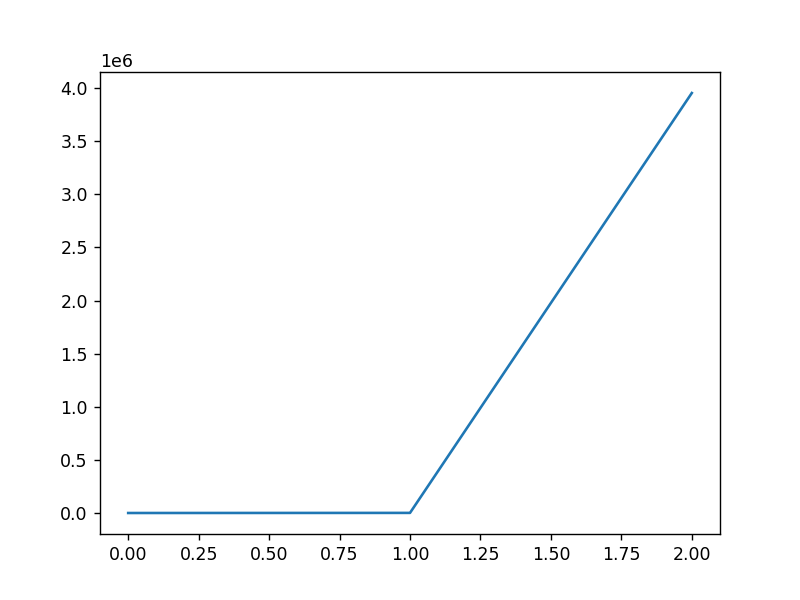

In [42]:
# a very sharp increase in fare values can be seen 
# plotting last three total fare values, and we can observe there is share increase in the values
plt.plot(var[-3:])
plt.show()

<IPython.core.display.Javascript object>


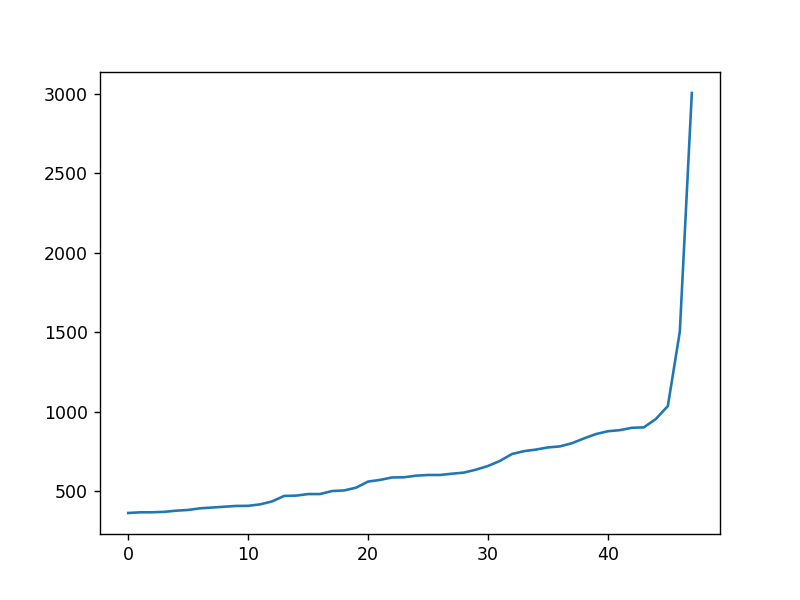

In [43]:
#now looking at values not including the last two points we again find a drastic increase at around 1000 fare value
# we plot last 50 values excluding last two values
plt.plot(var[-50:-2])
plt.show()

# Remove all outliers/erronous points

In [44]:
def remove_outliers(new_frame):

    
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [45]:
new_frame_cleaned = frame_with_durations_modified[(((frame_with_durations_modified.pickup_latitude >= 40.5774) & (frame_with_durations_modified.pickup_latitude <= 40.9176)) & ((frame_with_durations_modified.pickup_longitude >= -74.15) & (frame_with_durations_modified.pickup_longitude <= -73.7004)))]

In [46]:
m = folium.Map(location = [40.9176, -73.7004], tiles = "Stamen Toner")

pickups_within_NYC = new_frame_cleaned.sample(n = 500)

for i,j in pickups_within_NYC.iterrows():
    folium.Marker([j["pickup_latitude"], j["pickup_longitude"]]).add_to(m)

In [47]:
new_frame_cleaned = frame_with_durations_modified[(((frame_with_durations_modified.dropoff_latitude >= 40.5774) & (frame_with_durations_modified.dropoff_latitude <= 40.9176)) & ((frame_with_durations_modified.dropoff_longitude >= -74.15) & (frame_with_durations_modified.dropoff_longitude <= -73.7004)))]

In [48]:
m = folium.Map(location = [40.9176, -73.7004], tiles = "Stamen Toner")

dropoff_within_NYC = new_frame_cleaned.sample(n = 500)

for i,j in dropoff_within_NYC.iterrows():
    folium.Marker([j["dropoff_latitude"], j["dropoff_longitude"]]).add_to(m)

# Data-preperation
## Clustering/Segmentation

In [49]:
coord = new_frame_cleaned[["pickup_latitude", "pickup_longitude"]].values
neighbors = []

def min_distance(regionCenters, totalClusters):
    good_points = 0
    bad_points = 0
    less_dist = []
    more_dist = []
    min_distance = 100000  #any big number can be given here
    for i in range(totalClusters):
        good_points = 0
        bad_points = 0
        for j in range(totalClusters):
            if j != i:
                distance = gpxpy.geo.haversine_distance(latitude_1 = regionCenters[i][0], longitude_1 = regionCenters[i][1], latitude_2 = regionCenters[j][0], longitude_2 = regionCenters[j][1])
                #you can check the documentation of above "gpxpy.geo.haversine_distance" at "https://github.com/tkrajina/gpxpy/blob/master/gpxpy/geo.py"
                #"gpxpy.geo.haversine_distance" gives distance between two latitudes and longitudes in meters. So, we have to convert it into miles.
                distance = distance/(1.60934*1000)   #distance from meters to miles
                min_distance = min(min_distance, distance) #it will return minimum of "min_distance, distance".
                if distance < 2:
                    good_points += 1
                else:
                    bad_points += 1
        less_dist.append(good_points)
        more_dist.append(bad_points)
    print("On choosing a cluster size of {}".format(totalClusters))
    print("Avg. Number clusters within vicinity where inter cluster distance < 2 miles is {}".format(np.ceil(sum(less_dist)/len(less_dist))))
    print("Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is {}".format(np.ceil(sum(more_dist)/len(more_dist))))
    print("Minimum distance between any two clusters = {}".format(min_distance))
    print("-"*10)
            
def makingRegions(noOfRegions):
    regions = MiniBatchKMeans(n_clusters = noOfRegions, batch_size = 10000).fit(coord)
    regionCenters = regions.cluster_centers_ 
    totalClusters = len(regionCenters)
    return regionCenters, totalClusters  

We want the minimum inter cluster distance between any two clusters to be less than 0.5miles and when number of clusters are 30 then this condition is almost meeting. Therefore, we are considering number of clusters to be 30. The MiniBatchKMeans is a variant of the KMeans algorithm which uses mini-batches to reduce the computation time, while still attempting to optimise the same objective function. Mini-batches are subsets of the input data, randomly sampled in each training iteration. These mini-batches drastically reduce the amount of computation required to converge to a local solution. In contrast to other algorithms that reduce the convergence time of k-means, mini-batch k-means produces results that are generally only slightly worse than the standard algorithm.

In [50]:
#startTime = datetime.now()
for i in range(10, 100, 10):
    regionCenters, totalClusters = makingRegions(i)
    min_distance(regionCenters, totalClusters)
#print("Time taken = "+str(datetime.now() - startTime))

On choosing a cluster size of 10
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 3.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 7.0
Minimum distance between any two clusters = 0.8358785185178852
----------
On choosing a cluster size of 20
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 4.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 16.0
Minimum distance between any two clusters = 0.6684403540010347
----------
On choosing a cluster size of 30
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 7.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 23.0
Minimum distance between any two clusters = 0.5107833010234866
----------
On choosing a cluster size of 40
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 12.0
Avg. Number clusters outside of vicinity where int

In [51]:
coord = new_frame_cleaned[["pickup_latitude", "pickup_longitude"]].values
regions = MiniBatchKMeans(n_clusters = 30, batch_size = 10000).fit(coord)
new_frame_cleaned["pickup_cluster"] = regions.predict(new_frame_cleaned[["pickup_latitude", "pickup_longitude"]])

In [52]:
new_frame_cleaned.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421367e+09,5.285319,29
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420940e+09,9.983193,21
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420940e+09,10.746269,28
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420940e+09,16.071429,7
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420940e+09,9.318378,24


In [53]:
new_frame_cleaned=new_frame_cleaned.columns
new_frame_cleaned

Index(['passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'total_amount', 'trip_times', 'pickup_times', 'Speed',
       'pickup_cluster'],
      dtype='object')

In [54]:
centerOfRegions = regions.cluster_centers_
noOfClusters = len(centerOfRegions)
m = folium.Map(location = [40.9176, -73.7004], tiles = "Stamen Toner")

for i in range(noOfClusters):
    folium.Marker([centerOfRegions[i][0], centerOfRegions[i][1]], popup = (str(np.round(centerOfRegions[i][0], 2))+", "+str(np.round(centerOfRegions[i][1], 2)))).add_to(m)
m

# Validation

In [55]:
%%writefile testutility.py
import logging
import os
import subprocess
import yaml
import pandas as pd
import datetime 
import gc
import re


################
# File Reading #
################

def read_config_file(filepath):
    with open(filepath, 'r') as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            logging.error(exc)


def replacer(string, char):
    pattern = char + '{2,}'
    string = re.sub(pattern, char, string) 
    return string

def col_header_val(df,table_config):
    '''
    replace whitespaces in the column
    and standardized column names
    '''
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace('[^\w]','_',regex=True)
    df.columns = list(map(lambda x: x.strip('_'), list(df.columns)))
    df.columns = list(map(lambda x: replacer(x,'_'), list(df.columns)))
    expected_col = list(map(lambda x: x.lower(),  table_config['columns']))
    expected_col.sort()
    df.columns =list(map(lambda x: x.lower(), list(df.columns)))
    df = df.reindex(sorted(df.columns), axis=1)
    if len(df.columns) == len(expected_col) and list(expected_col)  == list(df.columns):
        print("column name and column length validation passed")
        return 1
    else:
        print("column name and column length validation failed")
        mismatched_columns_file = list(set(df.columns).difference(expected_col))
        print("Following File columns are not in the YAML file",mismatched_columns_file)
        missing_YAML_file = list(set(expected_col).difference(df.columns))
        print("Following YAML columns are not in the file uploaded",missing_YAML_file)
        logging.info(f'df columns: {df.columns}')
        logging.info(f'expected columns: {expected_col}')
        return 0

Overwriting testutility.py


In [56]:
%%writefile store.yaml

file_type: csv
dataset_name: file
file_name: yellow_tripdata_2015-01
table_name: new_frame_cleaned
inbound_delimiter: ","
outbound_delimiter: "|"
skip_leading_rows: 1
columns: 
    - passenger_count
      - trip_distance
      - pickup_longitude
      - pickup_latitude
      - dropoff_longitude
      - dropoff_latitude
      - total_amount
      - trip_times
      - pickup_times
      - Speed
      - pickup_cluster

Overwriting store.yaml


In [57]:
#Reading the file using config file
import testutility as util
config_data = util.read_config_file("store.yaml")

In [58]:
config_data['inbound_delimiter']

','

In [59]:
#inspecting data of config file
config_data

{'file_type': 'csv',
 'dataset_name': 'file',
 'file_name': 'yellow_tripdata_2015-01',
 'table_name': 'new_frame_cleaned',
 'inbound_delimiter': ',',
 'outbound_delimiter': '|',
 'skip_leading_rows': 1,
 'columns': ['passenger_count - trip_distance - pickup_longitude - pickup_latitude - dropoff_longitude - dropoff_latitude - total_amount - trip_times - pickup_times - Speed - pickup_cluster']}

In [60]:
import os

print(os.getcwd())

# Normal reading process of the file
import pandas as pd
#import dask.dataframe as dd

#%% time
import time
start_time = time.time()

df_sample = pd.read_csv("C:/Users/anmul/Downloads/yellow_tripdata_2015-01.csv",delimiter=',') 
#df_sample = pd.read_csv("/content/used_cars_data.csv",delimiter=',') 

print("--- %s seconds ---" % (time.time() - start_time))

df_sample.head()
df_sample.info()

C:\Users\anmul\Downloads
--- 42.222885847091675 seconds ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12748986 entries, 0 to 12748985
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        int64  
 4   trip_distance          float64
 5   pickup_longitude       float64
 6   pickup_latitude        float64
 7   RateCodeID             int64  
 8   store_and_fwd_flag     object 
 9   dropoff_longitude      float64
 10  dropoff_latitude       float64
 11  payment_type           int64  
 12  fare_amount            float64
 13  extra                  float64
 14  mta_tax                float64
 15  tip_amount             float64
 16  tolls_amount           float64
 17  improvement_surcharge  float64
 18  total_amount           float64
dtypes: float64(12), int64(4), object(3)
memory usage: 1.8+ GB


In [61]:
import dask.dataframe as dd

#%%time
import time
start_time = time.time()

df_sample = dd.read_csv("C:/Users/anmul/Downloads/yellow_tripdata_2015-01.csv",delimiter=',', dtype={'tpep_pickup_datetime':'object','store_and_fwd_flag': 'object','RateCodeID': 'object'})

    

print("--- %s seconds ---" % (time.time() - start_time))

df_sample.head()
#df_sample.info()

--- 0.7450497150421143 seconds ---


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [62]:
# read the file using config file
print(os.getcwd())
file_type = config_data['file_type']
source_file = "C:/Users/anmul/Downloads/" + config_data['file_name'] + f'.{file_type}'
#print("",source_file)
df = pd.read_csv(source_file,config_data['inbound_delimiter'])
df.head()

C:\Users\anmul\Downloads


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [64]:
import pandas as pd
df = pd.read_csv(source_file,config_data['inbound_delimiter'])
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [65]:
#validate the header of the file
util.col_header_val(df,config_data)

column name and column length validation failed
Following File columns are not in the YAML file ['extra', 'tolls_amount', 'total_amount', 'dropoff_longitude', 'mta_tax', 'improvement_surcharge', 'payment_type', 'vendorid', 'fare_amount', 'dropoff_latitude', 'trip_distance', 'store_and_fwd_flag', 'pickup_latitude', 'pickup_longitude', 'ratecodeid', 'tip_amount', 'passenger_count', 'tpep_dropoff_datetime', 'tpep_pickup_datetime']
Following YAML columns are not in the file uploaded ['passenger_count - trip_distance - pickup_longitude - pickup_latitude - dropoff_longitude - dropoff_latitude - total_amount - trip_times - pickup_times - speed - pickup_cluster']


0

In [67]:
print("columns of files are:" ,df.columns)
print("columns of YAML are:" ,config_data['columns'])

columns of files are: Index(['vendorid', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'ratecodeid', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')
columns of YAML are: ['passenger_count - trip_distance - pickup_longitude - pickup_latitude - dropoff_longitude - dropoff_latitude - total_amount - trip_times - pickup_times - Speed - pickup_cluster']


In [68]:
if util.col_header_val(df,config_data)==0:
    print("validation failed")
    # write code to reject the file
else:
    print("col validation passed")
    # write the code to perform further action
    # in the pipleine

column name and column length validation failed
Following File columns are not in the YAML file ['extra', 'tolls_amount', 'total_amount', 'dropoff_longitude', 'mta_tax', 'improvement_surcharge', 'payment_type', 'vendorid', 'fare_amount', 'dropoff_latitude', 'trip_distance', 'store_and_fwd_flag', 'pickup_latitude', 'pickup_longitude', 'ratecodeid', 'tip_amount', 'passenger_count', 'tpep_dropoff_datetime', 'tpep_pickup_datetime']
Following YAML columns are not in the file uploaded ['passenger_count - trip_distance - pickup_longitude - pickup_latitude - dropoff_longitude - dropoff_latitude - total_amount - trip_times - pickup_times - speed - pickup_cluster']
validation failed


In [83]:
#Output gz file
df_sample.to_csv('yellow_tripdata_2015.csv.gz',
          sep='|',
          header=True,
          index=False,
          quoting=csv.QUOTE_ALL,
          compression='gzip',
          quotechar='"',
          doublequote=True,
          line_terminator='\n')

['C:/Users/anmul/Downloads/yellow_tripdata_2015.csv.gz\\00.part',
 'C:/Users/anmul/Downloads/yellow_tripdata_2015.csv.gz\\01.part',
 'C:/Users/anmul/Downloads/yellow_tripdata_2015.csv.gz\\02.part',
 'C:/Users/anmul/Downloads/yellow_tripdata_2015.csv.gz\\03.part',
 'C:/Users/anmul/Downloads/yellow_tripdata_2015.csv.gz\\04.part',
 'C:/Users/anmul/Downloads/yellow_tripdata_2015.csv.gz\\05.part',
 'C:/Users/anmul/Downloads/yellow_tripdata_2015.csv.gz\\06.part',
 'C:/Users/anmul/Downloads/yellow_tripdata_2015.csv.gz\\07.part',
 'C:/Users/anmul/Downloads/yellow_tripdata_2015.csv.gz\\08.part',
 'C:/Users/anmul/Downloads/yellow_tripdata_2015.csv.gz\\09.part',
 'C:/Users/anmul/Downloads/yellow_tripdata_2015.csv.gz\\10.part',
 'C:/Users/anmul/Downloads/yellow_tripdata_2015.csv.gz\\11.part',
 'C:/Users/anmul/Downloads/yellow_tripdata_2015.csv.gz\\12.part',
 'C:/Users/anmul/Downloads/yellow_tripdata_2015.csv.gz\\13.part',
 'C:/Users/anmul/Downloads/yellow_tripdata_2015.csv.gz\\14.part',
 'C:/Users

In [77]:
#number of files in gz format folder
import os
entries = os.listdir('C:/Users/anmul/Downloads/yellow_tripdata_2015.csv.gz/')
for entry in entries:
    print(entry)

00.part
01.part
02.part
03.part
04.part
05.part
06.part
07.part
08.part
09.part
10.part
11.part
12.part
13.part
14.part
15.part
16.part
17.part
18.part
19.part
20.part
21.part
22.part
23.part
24.part
25.part
26.part
27.part
28.part
29.part
30.part
31.part


In [78]:
#size of the gz format folder
os.path.getsize('C:/Users/anmul/Downloads/yellow_tripdata_2015.csv.gz')

12288

In [81]:
len(df_sample.columns)

19

In [85]:
os.path.getsize('C:/Users/anmul/Downloads/yellow_tripdata_2015.csv')

1985964692